In [11]:
'''
this code shows the implementation of graphlet_sampling kernel ( which is expected to have the higher accuracy
than random features_based kernels, but much longer computational time)
'''
!pip install grakel 
import time 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import networkx as nx
import grakel as gk 

from grakel.datasets import fetch_dataset
from grakel.kernels import ShortestPath
from grakel.kernels import GraphletSampling

     |████████████████████████████████| 1.7MB 2.9MB/s 
     |████████████████████████████████| 163kB 58.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# DataSet Loading 

class dataset_loading:
    def __init__(self):
        pass 
    #mutag dataset
    def mutag(self,test_size=0.1):
        Gnx_train=[];
        Gnx_test=[];
        MUTAG = fetch_dataset("MUTAG", verbose=False,as_graphs=False)
        G, y = MUTAG.data, MUTAG.target
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1)
        for i in range(len(G_train)):
            g_current=nx.Graph(list(G_train[i][2]));
            g_current.add_nodes_from(G_train[i][1])
            Gnx_train.append(g_current)
        for i in range(len(G_test)):
            g_current=nx.Graph(list(G_test[i][2]));
            g_current.add_nodes_from(G_test[i][1])
            Gnx_test.append(g_current)
        return (Gnx_train,y_train), (Gnx_test,y_test)

    #SBM generator
    def generate_SBM(self,Graphs_num=300,nodes_per_graph=60,block_size=10,fraction=0.3,mult_factor=1.2,avg_deg=10,test_size=0.2):
        blocks_num=int(nodes_per_graph/block_size)
        sizes=[block_size]*blocks_num
        G,y=[],[]
        for i in range (Graphs_num):                  
            p_in=fraction  if i <Graphs_num/2 else fraction*mult_factor
            p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
            p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)
            #print(p_in,p_out)
            G_cur=nx.stochastic_block_model(sizes, p)
            adj=[(i,j) for (i,j,_) in G_cur.edges(data=True)]
            node_labels=dict ((i,list(val.values())[0]) for (i,val) in G_cur.nodes(data=True) )
            
            G.append(gk.Graph(adj, node_labels=node_labels))
            y.append(-1 if i<Graphs_num/2 else 1)            
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        return (G_train,y_train),(G_test,y_test)
        

    # DD dataset
    def DD(self,test_size=0.1,train_size=800):
        DD = fetch_dataset("DD", verbose=True)
        G, y = DD.data, DD.target
        Gnx_train=[];
        Gnx_test=[];           # Taking just Train_size graphs of the data set as training set, 
                                       #this is due to the large computatational time
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        G_train,y_train=G_train[0:Train_size], y_train[0:Train_size]
        for i in range(len(G_train)):
            g_current=nx.Graph(list(G_train[i][0]));
            g_current.add_nodes_from(G_train[i][1])
            Gnx_train.append(g_current)
        for i in range(len(G_test)):
            g_current=nx.Graph(list(G_test[i][0]));
            g_current.add_nodes_from(G_test[i][1])
            Gnx_test.append(g_current)
        return (Gnx_train,y_train), (Gnx_test,y_test)


In [22]:
nodes_num, mult_factor= range (4,5), 1+np.linspace(0.2,2,18)
results=np.array([])
results_time=np.array([])

for (nodes_ind, nodes) in enumerate(nodes_num):
  for (factor_in, factor) in enumerate (mult_factor):
    start_time=time.time()
    (G_train,y_train) ,(G_test, y_test) = dataset_loading().generate_SBM(Graphs_num=300, test_size=0.2, mult_factor=factor)
    # Uses the shortest path kernel to generate the kernel matrices
    kernel = GraphletSampling(k=nodes)
    print('computing kernel matrix for the training set')
    #kernel = ShortestPath(normalize=True)
    K_train = kernel.fit_transform(G_train)
    print('computing the kernel matrix for the test set')
    K_test = kernel.transform(G_test)
    print('Applying SVC on the former matrix')
    # Uses the SVM classifier to perform classification
    clf = SVC(kernel="precomputed")
    clf.fit(K_train, y_train)
    print('Testing the model and calculating the test accuracy')
    y_pred = clf.predict(K_test)
    # Computes and prints the classification accuracy
    acc = accuracy_score(y_test, y_pred)
    results=np.append(results,acc)
    results_time=np.append(results_time,float(time.time() - start_time))
    print("Accuracy of value ",str(factor), ":", str(round(acc*100, 2)) + "%")
    print(" time :--- %s seconds ---" % (time.time() - start_time))
    np.savetxt('Graphlet_kernel_results4.csv', results, delimiter=',')
    np.savetxt('Graphlet_kernel_results4_time.csv', results_time, delimiter=',')

computing kernel matrix for the training set
computing the kernel matrix for the test set
Applying SVC on the former matrix
Testing the model and calculating the test accuracy
Accuracy of value  1.2 : 70.0%
 time :--- 654.9690098762512 seconds ---
computing kernel matrix for the training set
computing the kernel matrix for the test set
Applying SVC on the former matrix
Testing the model and calculating the test accuracy
Accuracy of value  1.3058823529411765 : 76.67%
 time :--- 622.5317900180817 seconds ---
computing kernel matrix for the training set
computing the kernel matrix for the test set
Applying SVC on the former matrix
Testing the model and calculating the test accuracy
Accuracy of value  1.4117647058823528 : 80.0%
 time :--- 545.1838631629944 seconds ---
computing kernel matrix for the training set
computing the kernel matrix for the test set
Applying SVC on the former matrix
Testing the model and calculating the test accuracy
Accuracy of value  1.5176470588235293 : 93.33%
 t

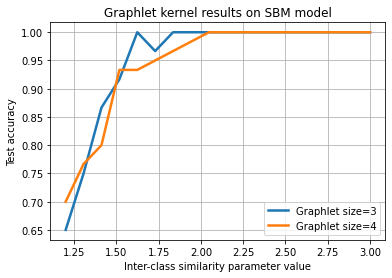

In [46]:
from  matplotlib import pyplot as plt
result3=np.loadtxt('Graphlet_kernel_results3.csv')
result4=np.loadtxt('Graphlet_kernel_results4.csv')
plt.plot(mult_factor,result3,linewidth=2.5,label='Graphlet size=3')
plt.plot(mult_factor,result4,linewidth=2.5,label='Graphlet size=4')
plt.title('Graphlet kernel results on SBM model')
plt.xlabel('Inter-class similarity parameter value')
plt.ylabel('Test accuracy')
plt.grid()
plt.legend()
plt.savefig("GK Test Accuracy SBM.png")
plt.show()


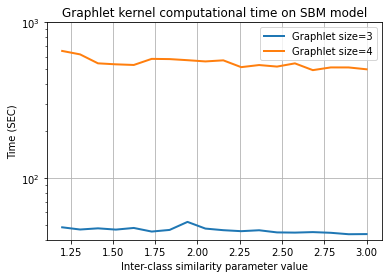

In [47]:
result3_time=np.loadtxt('Graphlet_kernel_results3_time.csv')
result4_time=np.loadtxt('Graphlet_kernel_results4_time.csv')
plt.plot(mult_factor,result3_time,linewidth=2,label='Graphlet size=3')
plt.plot(mult_factor,result4_time,linewidth=2,label='Graphlet size=4')
plt.title('Graphlet kernel computational time on SBM model')
plt.xlabel('Inter-class similarity parameter value')
plt.ylabel('Time (SEC)')

plt.yscale('log')
plt.grid()
plt.legend()
plt.ylim(40,1000)
plt.savefig("GK Computational time.png")
plt.show()